# NLP Analysis of The Office

This analysis is possible thanks to the delightful [schrutepy](https://github.com/bradlindblad/schrutepy) package, available [on PyPI](https://pypi.org/project/schrutepy/).

In [1]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from scipy import ndimage, stats
from sklearn.metrics import pairwise

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

import nltk
import gensim
from wordcloud import wordcloud

from schrutepy import schrutepy

## Data loading and cleaning

We start by applying some data cleaning and processing which was developed by iteratively double-checking things like the unique list of character names.  We tokenize the text in a straightforward way.

In [2]:
def clean_character(data):
    def f(c):
        c = str(c)
        out = c.strip('". ')
        return out
    data['character'] = data['character'].map(f).str.title()
    data['character'] = data['character'].str.replace("'S", "'s")
    # clean specific characters
    ch = data['character']
    data.loc[ch.str.contains('Hele'),'character'] = 'Helene'
    data.loc[ch.str.contains('Pam.s Mom'),'character'] = 'Helene'
    for misspell in 'Anglea Angels'.split():
        data.loc[ch == misspell, 'character'] = 'Angela'
    data.loc[ch.str.contains('Bob Vance'), 'character'] = 'Bob Vance'
    data.loc[ch == 'Cameraman', 'character'] = 'Camera Man'
    data.loc[ch == 'Chares', 'character'] = 'Charles'
    for misspell in 'Dacvid Wallcve'.split():
        data.loc[ch.str.contains(misspell), 'character'] = 'David Wallace'
    for misspell in 'Darrly Darry Daryl'.split():
        data.loc[ch == misspell, 'character'] = 'Darryl'
    data.loc[ch == 'Glen', 'character'] = 'Glenn'
    data.loc[ch.str.contains('^Hank'), 'character'] = 'Hank'
    data.loc[ch == 'Holy', 'character']  = 'Holly'
    data.loc[ch == 'M Ichael', 'character'] = 'Michael'
    data.loc[ch == 'Jo', 'character'] = 'Jo Bennett'
    data.loc[ch.str.contains('Phylis'), 'character'] = 'Phyllis'
    data.loc[ch == 'Rolf', 'character'] = 'Rolph'
    # normalize 'and' notation
    for and_spelling in [' ?& ?', ' ?/ ?', ' And ']:
        data['character'] = data['character'].str.replace(and_spelling, ' and ')
    
def clean_text(data):
    data['text'] = data['text'].map(str)
    text_lower = data['text'].str.lower()
    data['sents'] = text_lower.map(nltk.sent_tokenize)
    data['words'] = text_lower.map(nltk.tokenize.RegexpTokenizer(r"[\w']+").tokenize)
    data['sents'] = data['sents'].map(np.array)
    data['words'] = data['words'].map(np.array)
    data['n_sents'] = data['sents'].map(len)
    data['n_words'] = data['words'].map(len)

def prep_schrute():
    data = schrutepy.load_schrute()
    clean_character(data)
    clean_text(data)
    return data

In [3]:
%time data = prep_schrute()

CPU times: user 4.47 s, sys: 126 ms, total: 4.6 s
Wall time: 5.32 s


In [4]:
data.head()

index  season  episode episode_name    director  \
0      1       1        1        Pilot  Ken Kwapis   
1      2       1        1        Pilot  Ken Kwapis   
2      3       1        1        Pilot  Ken Kwapis   
3      4       1        1        Pilot  Ken Kwapis   
4      5       1        1        Pilot  Ken Kwapis   

                                        writer character  \
0  Ricky Gervais;Stephen Merchant;Greg Daniels   Michael   
1  Ricky Gervais;Stephen Merchant;Greg Daniels       Jim   
2  Ricky Gervais;Stephen Merchant;Greg Daniels   Michael   
3  Ricky Gervais;Stephen Merchant;Greg Daniels       Jim   
4  Ricky Gervais;Stephen Merchant;Greg Daniels   Michael   

                                                text  \
0  All right Jim. Your quarterlies look very good...   
1         Oh, I told you. I couldn't close it. So...   
2  So you've come to the master for guidance? Is ...   
3         Actually, you called me in here, but yeah.   
4    All right. Well, let me show you how it's done.   

                                    text_w_direction  \
0  All right Jim. Your quarterlies look very good...   
1         Oh, I told you. I couldn't close it. So...   
2  So you've come to the master for guidance? Is ...   
3         Actually, you called me in here, but yeah.   
4    All right. Well, let me show you how it's done.   

                                               sents  \
0  [all right jim., your quarterlies look very go...   
1     [oh, i told you., i couldn't close it., so...]   
2  [so you've come to the master for guidance?, i...   
3       [actually, you called me in here, but yeah.]   
4  [all right., well, let me show you how it's do...   

                                               words  n_sents  n_words  
0  [all, right, jim, your, quarterlies, look, ver...        3       14  
1     [oh, i, told, you, i, couldn't, close, it, so]        3        9  
2  [so, you've, come, to, the, master, for, guida...        2       14  
3   [actually, you, called, me, in, here, but, yeah]        1        8  
4  [all, right, well, let, me, show, you, how, it...        2       10

## Initial exploration

We'll focus a lot of our analysis on the main characters.  Here are the top-20 characters in terms of number of lines:

In [5]:
all_characters = data.groupby('character').count()[['index']].sort_values('index', ascending=False).index.values
main_characters = all_characters[:20]
main_characters

array(['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin',
       'Erin', 'Oscar', 'Darryl', 'Ryan', 'Phyllis', 'Kelly', 'Toby',
       'Jan', 'Stanley', 'Meredith', 'Holly', 'Nellie', 'Gabe'],
      dtype=object)

We'll also keep a longer list of many (~100) characters:

In [6]:
many_characters = list(all_characters[:110])
for generic in 'All Woman Nurse Crowd Everyone Group'.split():
    many_characters.remove(generic)
many_characters = np.array(many_characters)[:100]
np.sort(many_characters)

array(['Aj', 'Alan', 'Alice', 'Andy', 'Angela', 'Bar Manager',
       'Ben Franklin', 'Bert', 'Billy Merchant', 'Blood Girl', 'Bob',
       'Bob Vance', 'Brandon', 'Brian', 'Captain Jack', 'Carol', 'Casey',
       'Cathy', 'Charles', 'Christian', 'Clark', 'Creed', 'Danny',
       'Darryl', 'David', 'David Wallace', 'Deangelo', 'Donna', 'Dwight',
       'Elizabeth', 'Eric', 'Erin', 'Esther', 'Ex-Client', 'Fannie',
       'Gabe', 'Goldenface', 'Grotti', 'Guy', 'Hank', 'Hannah', 'Harry',
       'Helene', 'Holly', 'Host', 'Irene', 'Isabel', 'Jada', 'Jake',
       'Jan', 'Jessica', 'Jim', 'Jo Bennett', 'Josh', 'Karen', 'Katy',
       'Kelly', 'Kevin', 'Lester', 'Lonny', 'Luke', 'Man', 'Mark',
       'Martin', 'Meredith', 'Michael', 'Mose', 'Mr. Brown', 'Nate',
       'Nellie', 'Nick', 'Oscar', 'Packer', 'Pam', 'Pete', 'Phyllis',
       'Pizza Guy', 'Prince Grandfather', 'Rachel', 'Receptionist',
       'Robert', 'Robert California', 'Rolph', 'Roy', 'Ryan',
       'Ryan Howard', 'Senator', '

### Longest Monologues

In [7]:
ch = data['character']
print('Longest monologues by sentences')
for c in main_characters:
    print('{:>10s}: {:2d} sentences'.format(c, max(data[ch == c]['n_sents'])))

Longest monologues by sentences
   Michael: 28 sentences
    Dwight: 18 sentences
       Jim: 15 sentences
       Pam: 29 sentences
      Andy: 16 sentences
    Angela: 28 sentences
     Kevin: 12 sentences
      Erin: 14 sentences
     Oscar: 10 sentences
    Darryl: 10 sentences
      Ryan: 12 sentences
   Phyllis:  5 sentences
     Kelly: 11 sentences
      Toby:  8 sentences
       Jan:  9 sentences
   Stanley:  9 sentences
  Meredith: 13 sentences
     Holly:  8 sentences
    Nellie: 12 sentences
      Gabe: 10 sentences


In [8]:
ch = data['character']
print('Longest monologues by characters')
for c in main_characters:
    print('{:>10s}: {:3d} words'.format(c, max(data[ch == c]['n_words'])))

Longest monologues by characters
   Michael: 163 words
    Dwight: 114 words
       Jim: 146 words
       Pam: 232 words
      Andy: 134 words
    Angela: 124 words
     Kevin:  73 words
      Erin: 137 words
     Oscar:  62 words
    Darryl:  73 words
      Ryan:  92 words
   Phyllis:  62 words
     Kelly: 125 words
      Toby:  68 words
       Jan: 129 words
   Stanley:  65 words
  Meredith:  48 words
     Holly:  77 words
    Nellie: 114 words
      Gabe:  73 words


### Number of words/sentences per episode by character

In [9]:
seas_eps = list(data.groupby(['season', 'episode']).groups.keys())
len(seas_eps), seas_eps[:9]

(186, [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3)])

In [10]:
sents_per_episode = defaultdict(list)
words_per_episode = defaultdict(list)
for (s,e) in seas_eps:
    d = data[(data['season'].values == s) & (data['episode'].values == e)]
    for c in main_characters:
        dw = d['n_words'].values[d['character'] == c]
        words_per_episode[c].append(np.sum(dw))
        ds = d['n_sents'].values[d['character'] == c]
        sents_per_episode[c].append(np.sum(ds))
words_per_episode = pd.DataFrame(words_per_episode, index=seas_eps)
sents_per_episode = pd.DataFrame(sents_per_episode, index=seas_eps)

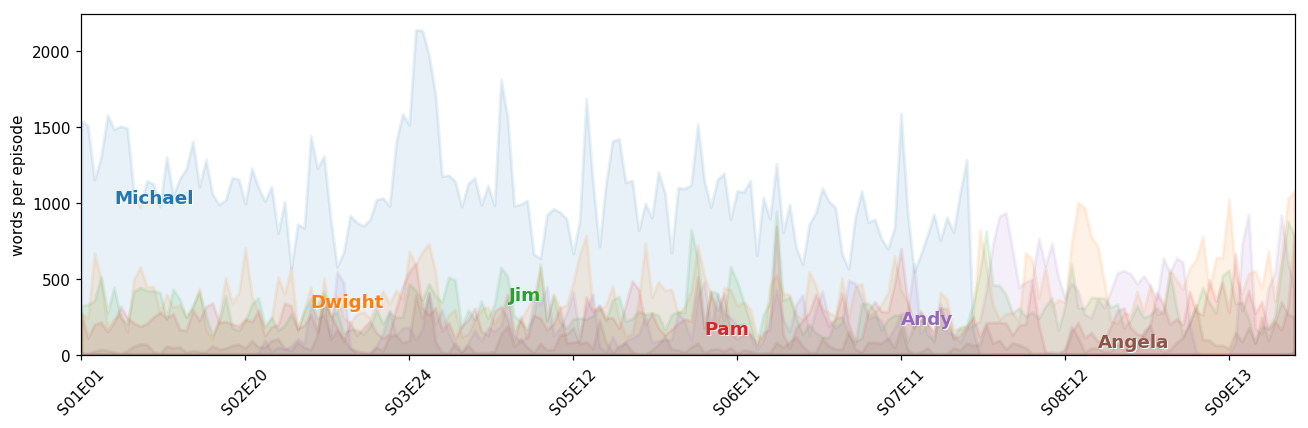

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
ov = np.zeros(len(words_per_episode))
v = ov.copy()
r = np.arange(len(ov))
for (i,c) in enumerate(main_characters[:6]):
    vv = ndimage.gaussian_filter(1. * words_per_episode[c].values, .5)
    v += vv
    color = f'C{i%10}'
    ax.fill_between(r, 0, vv, alpha=.1, color=color, lw=2)
    ix = 5 + 30 * i
    ax.text(ix, 20 + .66 * vv[ix], c, color=color, weight='bold', size='large', zorder=20)
    ax.text(ix + .15, 20 + .66 * vv[ix] - 5, c, color='w', weight='bold', size='large', zorder=19)
    ov = v.copy()
ax.set_xlim(r[[0,-1]])
ax.set_ylim(0)
xticks = ax.get_xticks().astype(int)
ax.set_xticklabels(['S{:02d}E{:02d}'.format(*seas_eps[i]) for i in xticks[xticks<r[-1]]], rotation=45)
ax.set_ylabel('words per episode')
plt.tight_layout()

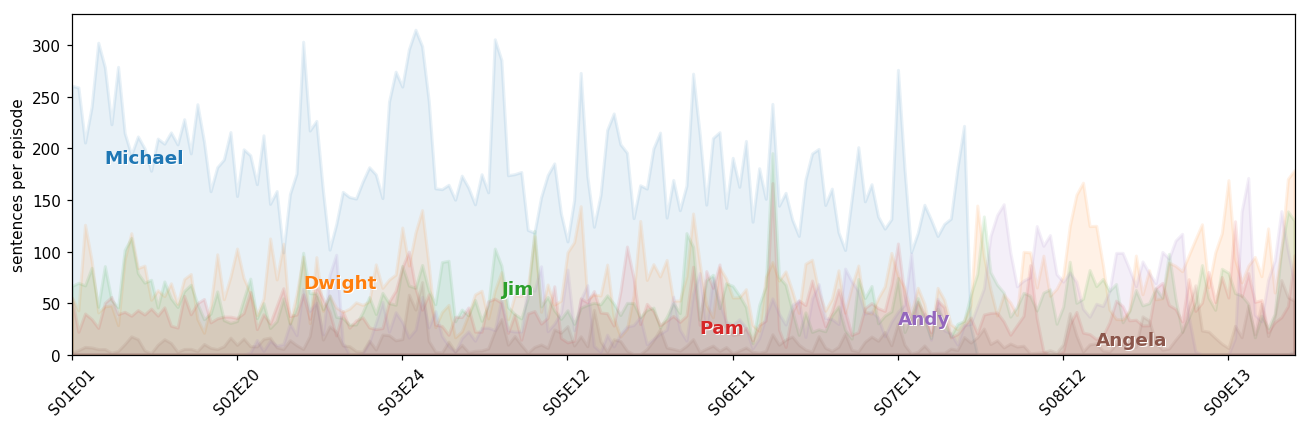

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
ov = np.zeros(len(words_per_episode))
v = ov.copy()
r = np.arange(len(ov))
for (i,c) in enumerate(main_characters[:6]):
    vv = ndimage.gaussian_filter(1. * sents_per_episode[c].values, .5)
    v += vv
    color = f'C{i%10}'
    ax.fill_between(r, 0, vv, alpha=.1, color=color, lw=2)
    ix = 5 + 30 * i
    ax.text(ix, 2 + .66 * vv[ix], c, color=color, weight='bold', size='large', zorder=20)
    ax.text(ix + .15, 2 + .66 * vv[ix] - 1, c, color='w', weight='bold', size='large', zorder=19)
    ov = v.copy()
ax.set_xlim(r[[0,-1]])
ax.set_ylim(0)
xticks = ax.get_xticks().astype(int)
ax.set_xticklabels(['S{:02d}E{:02d}'.format(*seas_eps[i]) for i in xticks[xticks<r[-1]]], rotation=45)
ax.set_ylabel('sentences per episode')
plt.tight_layout()

## Per-character wordclouds

My first question is: what are the main characters most often talking about?  We can visualize this nicely with some wordclouds.

First, we calculate some full-series word counts and tune a list of stopwords.

In [13]:
def wordcount(df, stopwords=[]):
    all_words = np.concatenate(df['words'].values)
    cd = Counter(all_words)
    for word in stopwords:
        if word in cd:
            del cd[word]
    word_counts = pd.DataFrame(list(cd.items()), columns='word count'.split()).sort_values('count', ascending=False)
    return word_counts

In [14]:
word_counts = wordcount(data)
stopwords = list(word_counts['word'][:200].values)
for word in stopwords:
    if word in list(map(str.lower, many_characters)) or word in 'think love wow feel sorry'.split():
        stopwords.remove(word)
stopwords = np.array(stopwords)

In [15]:
np.sort(stopwords)

array(['a', 'about', 'actually', 'all', 'alright', 'am', 'an', 'and',
       'any', 'anything', 'are', 'as', 'at', 'back', 'be', 'because',
       'been', 'better', 'big', 'but', 'by', 'call', 'can', "can't",
       'come', 'could', 'day', 'did', "didn't", 'do', 'does', "doesn't",
       'doing', "don't", 'down', 'even', 'ever', 'everybody', 'everyone',
       'fine', 'first', 'for', 'from', 'get', 'give', 'go', 'god',
       'going', 'gonna', 'good', 'got', 'great', 'guys', 'had', 'has',
       'have', 'he', "he's", 'hello', 'her', 'here', 'hey', 'hi', 'him',
       'his', 'how', 'i', "i'll", "i'm", "i've", 'if', 'in', 'into', 'is',
       'it', "it's", 'job', 'just', 'kind', 'know', 'last', 'let',
       "let's", 'like', 'little', 'look', 'lot', 'make', 'maybe', 'me',
       'mean', 'more', 'much', 'my', 'need', 'never', 'new', 'nice', 'no',
       'not', 'now', 'of', 'off', 'office', 'oh', 'ok', 'okay', 'on',
       'one', 'only', 'or', 'our', 'out', 'over', 'paper', 'party',
      

**Data Tweak:** let's filter the per-line word lists for stopwords:

In [16]:
data['words_filtered'] = [words[~np.in1d(words, stopwords)] for words in data['words'].values]

Now we're ready to display the wordclouds:

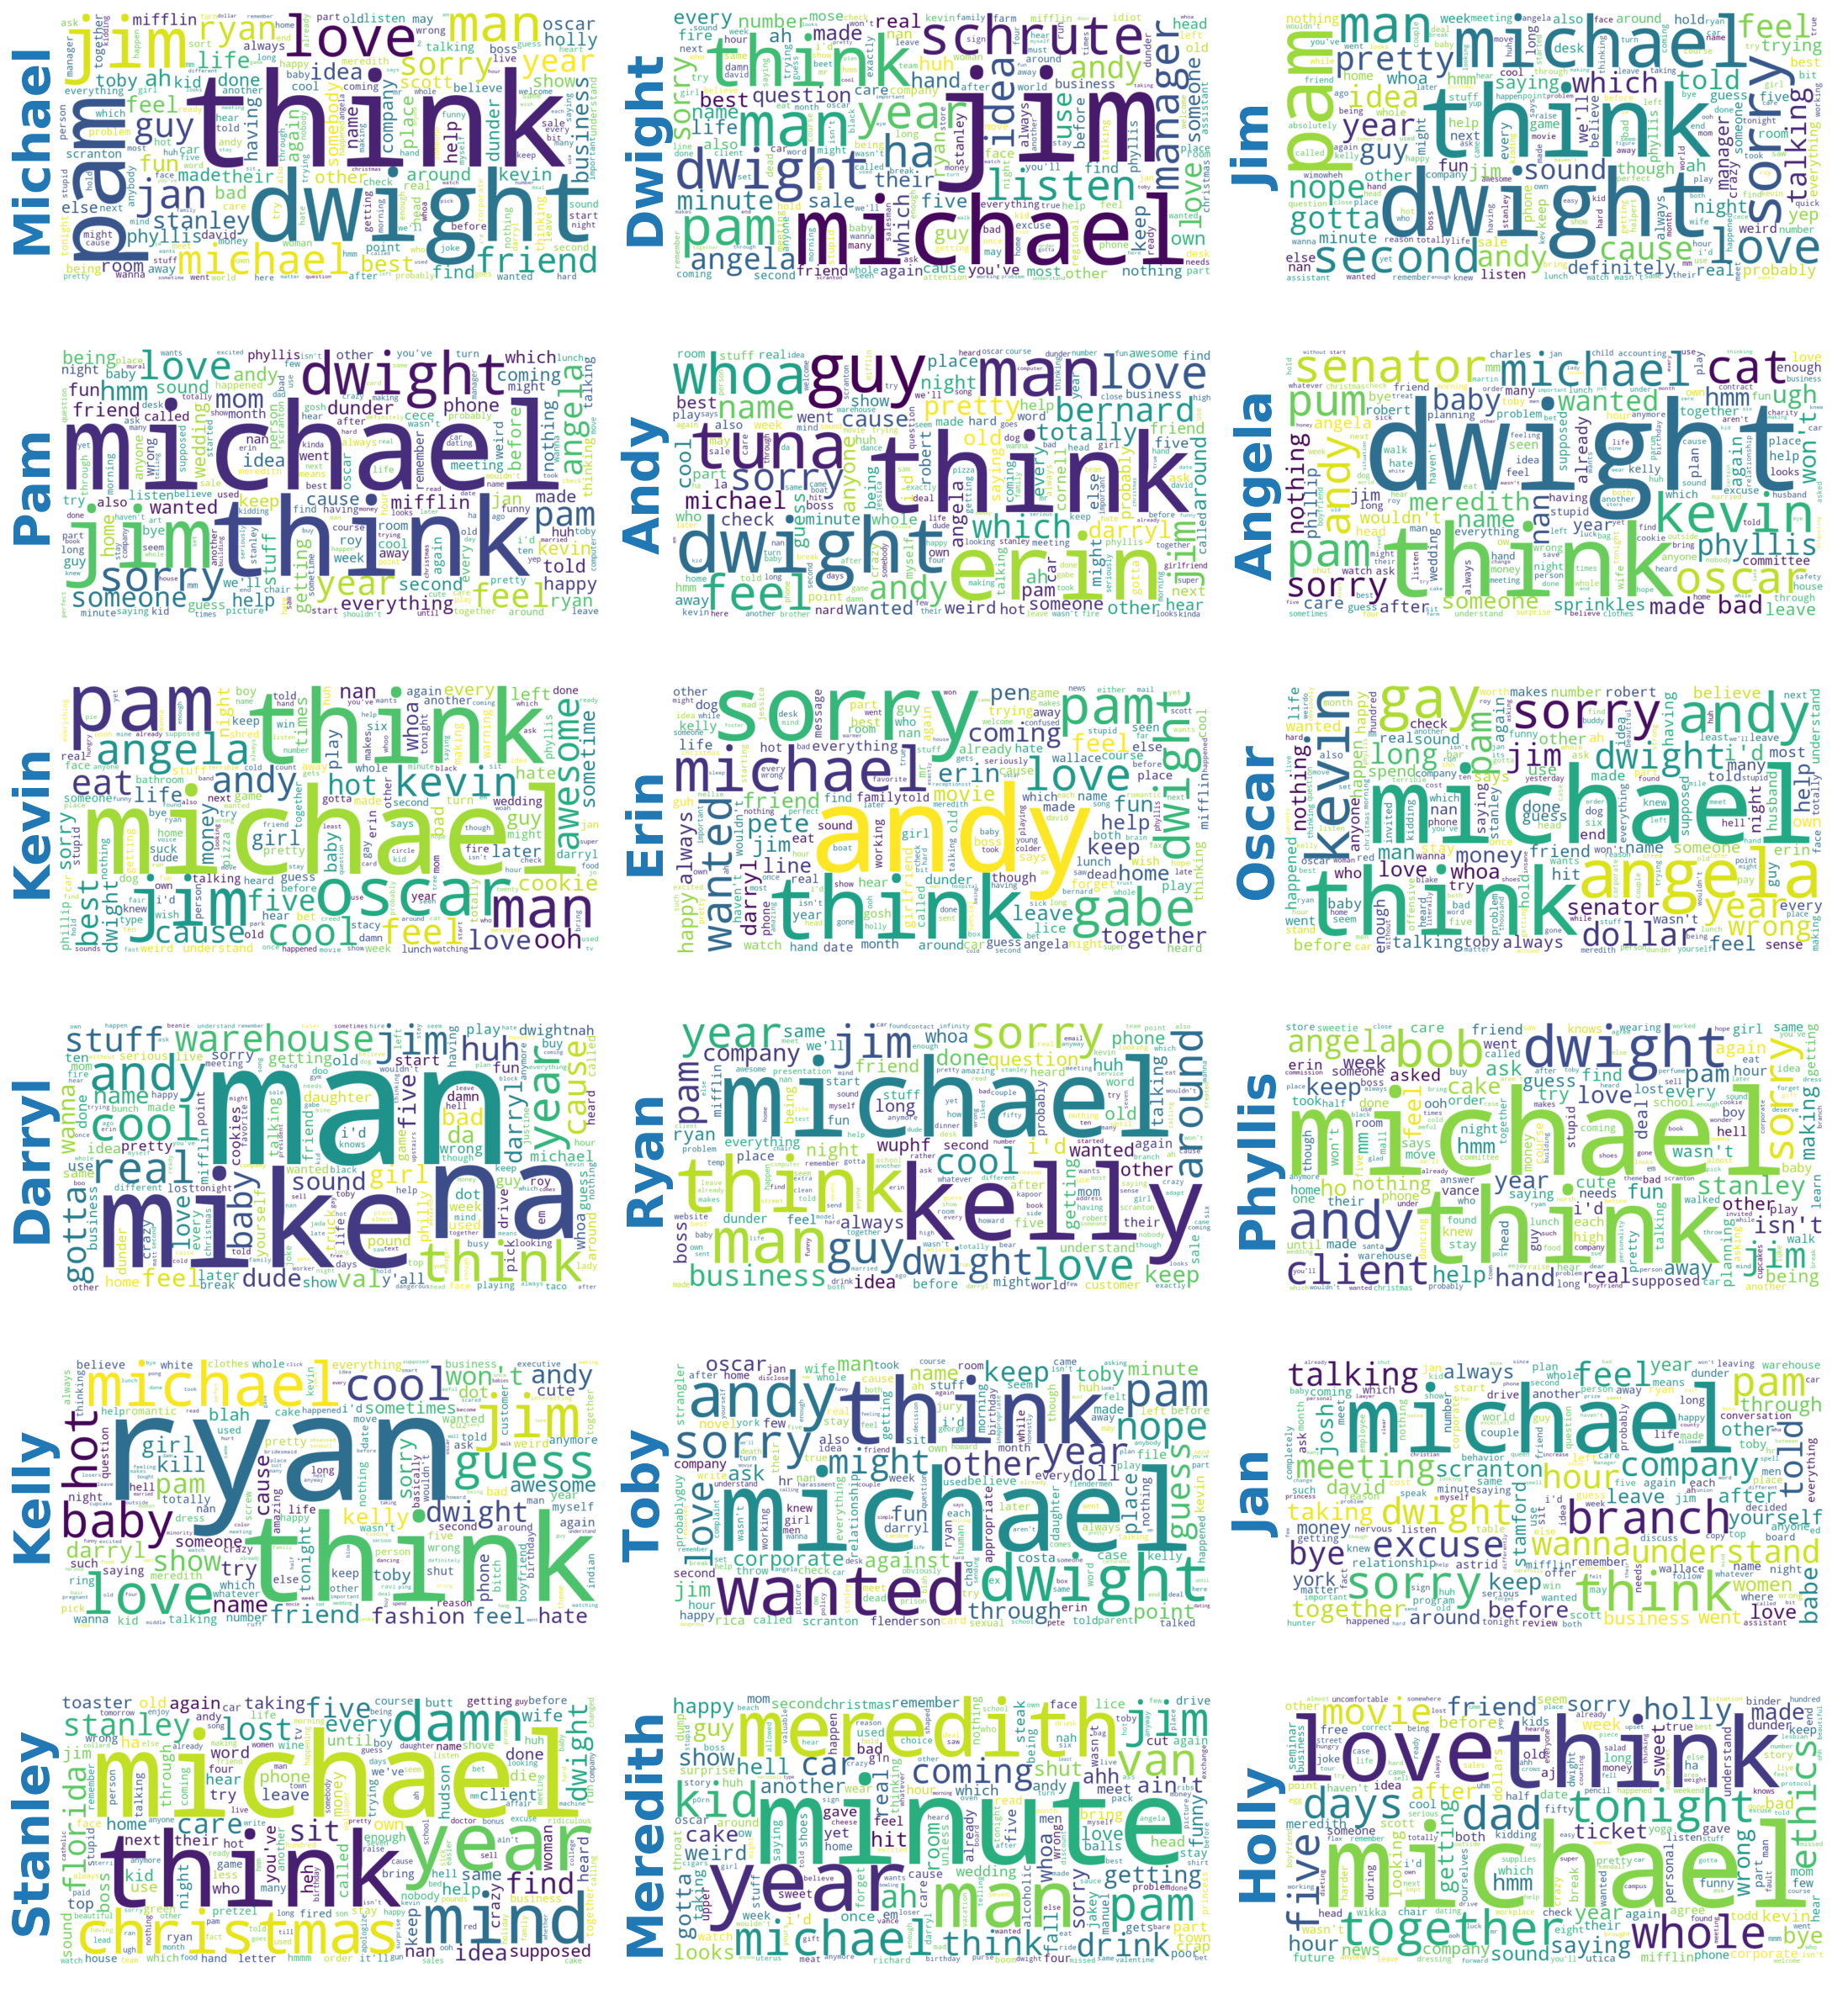

In [17]:
fig, axs = plt.subplots(6, 3, figsize=(22,24), dpi=100)
axs = np.ravel(axs)

wcg = wordcloud.WordCloud(
    width=1000, height=500,
    background_color='white', min_font_size=6,
    stopwords=stopwords, collocations=False,
    random_state=1)

for (ax, c) in zip(axs, main_characters[:len(axs)]):
    print(f'\r{c} ...' + 10 * ' ', end='', flush=True)
    wc = wcg.generate(' '.join(np.concatenate(data[ch == c]['words'].values)))
    ax.imshow(wc, interpolation='bilinear')
    ax.set_axis_off()
    ax.text(-.05, .5, c, color='C0', size=42, weight='bold',
            transform=ax.transAxes, va='center', ha='center', rotation=90)

print('\r' + 30 * ' ')

plt.tight_layout()

## Character-character mentions

Based on the above wordclouds, it may be interesting to investigate how often characters mention each other.

In [18]:
def get_mentioner_mention(data=data, characters=many_characters, pivot=True, norm_object=False, norm_speaker=False):
    sources = []
    targets = []
    counts = []
    for c1 in characters:
        idx = data['character'].values == c1
        all_words = list(np.concatenate(data['words'].values[idx]))
        for c2 in characters:
            sources.append(c1)
            targets.append(c2)
            counts.append(all_words.count(c2.lower()))
    out = pd.DataFrame(dict(speaker=sources, object=targets, count=counts))
    if pivot:
        out = out.pivot(index='speaker', columns='object', values='count')
        assert not (norm_object and norm_speaker)
        if norm_object:
            out = (out / out.sum(axis=0))
        if norm_speaker:
            out = (out.T / out.sum(axis=1)).T
    return out

In [19]:
get_mentioner_mention(characters=main_characters)

object    Andy  Angela  Darryl  Dwight  Erin  Gabe  Holly  Jan  Jim  Kelly  \
speaker                                                                      
Andy        42      33      41      80    78    16      1    6   48      8   
Angela      23      10       0      81     2     1      2    5   11      7   
Darryl      23       1      12      10     3     6      0    2   18      2   
Dwight      60      59      22     107    21    14     10   27  294     20   
Erin        92       9       9      23    15    26      5    0   12     10   
Gabe         7       1       7       4    19    17      0    0    7      2   
Holly        1       1       1       2     0     0      6    0    0      0   
Jan          1       2       1      10     0     0      1    5    6      1   
Jim         53      18      12     258     3     5      4    7   47     21   
Kelly       14       2      10      14     1     1      0    0   24     10   
Kevin       19      22       9      12     7     2      4    7   39      3   
Meredith     4       2       3       2     0     0      0    0    9      0   
Michael     67      48      58     353    44    19     86  154  228     35   
Nellie      17       6       7      38     3     0      0    0   13      0   
Oscar       29      37       3      22     9     3      1    5   16      4   
Pam         35      44      14     125    17     4      7   25  181     13   
Phyllis     26      11       1      34     6     1      0    1   13      1   
Ryan         3       2       5      16     5     1      2    3   18     41   
Stanley      3       0       0       8     0     0      1    1    6      2   
Toby        14       3       7      14     5     2      2    5    8      6   

object    Kevin  Meredith  Michael  Nellie  Oscar  Pam  Phyllis  Ryan  \
speaker                                                                 
Andy         20        11       40       9     19   34       19     6   
Angela       40        12       28       2     26   31       19     1   
Darryl        6         0       10       0      3    3        2     3   
Dwight       41        20      284      14     29  105       43    50   
Erin          4         5       37       4      5   28        6     3   
Gabe          0         2       12       0      1    6        0     0   
Holly         5         4       35       0      1    0        0     0   
Jan           0         0      159       0      0   14        1     5   
Jim          19        13      182       9     14  189       36    22   
Kelly         5         5       26       0      4   15        0    44   
Kevin        23         5       71       2     36   39        8     6   
Meredith      0        10        9       1      2    9        0     0   
Michael      95        68      169       1    100  327      120   143   
Nellie        4         1        0       2      0   17        7     2   
Oscar        34         6       65       3      6   22        4     5   
Pam          34        19      262       8     26   58       30    30   
Phyllis       2         1       59       1      2   11        1     2   
Ryan          7         0       43       2      2   15        3    11   
Stanley       2         1       27       0      1    3        1     4   
Toby          7         1       50       3      6   10        0     6   

object    Stanley  Toby  
speaker                  
Andy           19    11  
Angela          2     7  
Darryl          1     6  
Dwight         41    21  
Erin            5     1  
Gabe            0     2  
Holly           0     0  
Jan             0     6  
Jim            23    14  
Kelly           1     8  
Kevin           3     3  
Meredith        1     3  
Michael       133   101  
Nellie          2     5  
Oscar           5     9  
Pam            16    18  
Phyllis        11     2  
Ryan            5     2  
Stanley        10     0  
Toby            4     8

We can plot this as heatmaps showing raw counts or fraction of mentions normalized by speaker or person mentioned.  We exclude Michael since he simply speaks the most by such a large margin.

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

sns.heatmap(
    get_mentioner_mention(characters=main_characters[1:]),
    ax=axs[0], cmap='Blues_r', cbar_kws={'label': 'number of mentions'})

sns.heatmap(
    get_mentioner_mention(characters=main_characters[1:], norm_speaker=True),
    ax=axs[1], cmap='Blues_r', cbar_kws={'label': 'fraction of mentions by speaker'})

sns.heatmap(
    get_mentioner_mention(characters=main_characters[1:], norm_object=True),
    ax=axs[2], cmap='Blues_r', cbar_kws={'label': 'fraction of mentions of object'})

plt.tight_layout()

These mentions are reminiscent of a social network.  We can plot it as a network graph:

In [21]:
G = nx.Graph()
menmen = get_mentioner_mention(characters=many_characters[:50])
for c1 in menmen.index:
    for c2 in menmen.index:
        v = menmen[c2].loc[c1]
        if v:
            G.add_edge(c1, c2, weight=v)

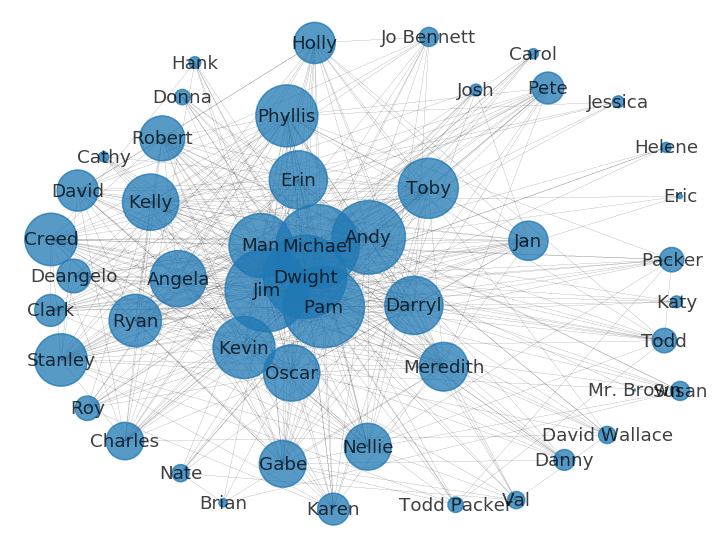

In [22]:
node_size = [G.degree(x)**2.1 for x in G]
nx.draw(G, pos=nx.spring_layout(G, k=4.25, seed=3), with_labels=True, node_size=node_size, width=.1, alpha=.75)

This visualization could certainly be improved, but for now we'll move on.

## Vocabulary modeling

We train a Word2Vec model on lines with more than 5 words:

In [23]:
office_sents = list(map(list,data['words'].values))

In [24]:
%time wv = gensim.models.Word2Vec([s for s in office_sents if len(s) > 5], size=50, min_count=5, workers=3)

CPU times: user 4.33 s, sys: 11.8 ms, total: 4.34 s
Wall time: 1.71 s


We'll use a couple of word2vec helper functions...

In [25]:
def most_similar(wv, words, *a, **kw):
    words = list(np.atleast_1d(words))
    words = [w for w in words if w in wv.wv]
    return wv.wv.most_similar(words, *a, **kw)

def get_vec(wv, words, *a, **kw):
    words = np.atleast_1d(words)
    words = [w for w in words if w in wv.wv]
    return np.mean([wv.wv[w] for w in words], axis=0)

... as well as helper functions for the specific comparisons we'd like to make:

In [26]:
def get_vecs(columns, data=data, wv=wv, only=None):
    gb = data.groupby(columns)
    vecs = {
        key: get_vec(wv, np.concatenate(d['words_filtered'].values))
        for (key, d) in gb
        if only is None or key in only
    }
    return vecs

def get_similarity(vecs, pivot=True):
    #vecs = get_vecs(columns, data=data, wv=wv, only=only)
    k1s, k2s, similaritys = [], [], []
    for k1 in vecs:
        for k2 in vecs:
            k1s.append(k1)
            k2s.append(k2)
            similaritys.append(1 - pairwise.euclidean_distances([vecs[k1]], [vecs[k2]])[0][0])
    similarity = pd.DataFrame(dict(k1=k1s, k2=k2s, s=similaritys))
    if pivot:
        similarity = similarity.pivot('k1', 'k2', 's')
    return similarity

## Vocab similarity: by character

Here's a character-by-character comparison, integrating over the entire show:

In [27]:
ax = sns.heatmap(get_similarity(get_vecs('character', only=main_characters)), cmap='Blues_r', cbar_kws=dict(label='similarity'))
ax.set_xlabel(''), ax.set_ylabel('');

We drill down to find the most and least similar pairs of characters:

In [28]:
sims = get_similarity(get_vecs('character', only=main_characters), pivot=False)
sims = sims[sims['k1'] < sims['k2']]
sims = sims.sort_values('s', ascending=False).reset_index(drop=True)

In [29]:
sims.head(10)

k1       k2         s
0  Michael     Ryan  0.942055
1      Pam  Phyllis  0.941179
2    Kevin    Oscar  0.938469
3     Andy   Darryl  0.938459
4      Jim      Pam  0.931678
5   Dwight   Nellie  0.929181
6     Erin      Pam  0.928955
7    Kevin      Pam  0.923740
8     Erin      Jim  0.922659
9    Oscar      Pam  0.918360

**Thoughts:**  These similarities seem plausible on the whole:
* Andy and Darryl jammed together.
* Pam and Phyllis bonded over many things, especially resisting Angela's party planning tyranny.
* Michael wanted to be like Ryan; Ryan wanted to be better than Michael... interesting pseudo-friendship.
* Kevin and Oscar both worked in accounting.
* Erin and Pam each had long stints as secretary.
* Dwight and Nellie did battle in office politics.
* Jim and Pam obviously started a family together.
* Erin and Jim, Kevin and Pam... not sure about these.
* Andy and Michael both served as manager.

In [30]:
sims.tail(10)

k1        k2         s
180     Jan   Michael  0.701940
181     Jan     Kelly  0.701366
182   Holly       Jan  0.697904
183  Dwight       Jan  0.669217
184     Jan   Stanley  0.657972
185    Andy       Jan  0.648126
186    Gabe       Jan  0.646866
187     Jan    Nellie  0.634863
188     Jan  Meredith  0.625306
189  Darryl       Jan  0.624089

**Thoughts:** Jan is *weird*.  I guess she really never fit in with the Scranton crew.  Some sample lines shown below reveal that she is resisting someone (usually Michael) in many of her lines.

In [31]:
d = data[ch == 'Jan']
np.random.seed(7)
d.iloc[np.random.randint(0, len(d), 30)]['text'].values

array(["I don't know what you're doing here, Michael,",
       'The cons are that everyone will lose their job. Michael. Everyone. Office, Warehouse. What do you think... the... pros... are... here?',
       'Is Michael in?', 'You son of a bitch!',
       "Michael, come on. Running away from your problems won't solve anything. You know that.",
       'Josh Porter, Stamford.',
       'That was my cheap suggestion. Chinese was my cheap suggestion.',
       "Oh, good. You're both here. Ready to talk logistics?",
       'Great! Uh-huh?', 'You went to a bachelor party at work?',
       "Michael that's irrational.", 'How was improv?',
       "It's... it's about talent.",
       "Uh, we don't know. Probably. A few.", 'Alright.', 'Well...',
       'You are not allowed in this session.',
       'Do you always shut down the entire office when you leave for an hour?',
       "It's nice.", 'Oh, God.',
       'After you ended... everything with us, I went on a vacation.',
       'Why would we need 

## Vocab similarity: by writer

We need to be a little careful about writers, since many episodes list multiple writers:

In [32]:
np.unique(data['writer'])

array(['Aaron Shure', 'Allison Silverman', 'Amelie Gillette',
       'Anthony Q. Farrell', 'B.J. Novak', 'Brent Forrester',
       'Brent Forrester;Justin Spitzer', 'Caroline Williams',
       'Carrie Kemper', 'Charlie Grandy', 'Dan Greaney', 'Dan Sterling',
       'Daniel Chun', 'Daniel Chun;Charlie Grandy',
       'Gene Stupnitsky;Lee Eisenberg', 'Graham Wagner', 'Greg Daniels',
       'Greg Daniels;Mindy Kaling', 'Halsted Sullivan;Warren Lieberstein',
       'Jason Kessler', 'Jennifer Celotta',
       'Jennifer Celotta;Greg Daniels',
       'Jennifer Celotta;Paul Lieberstein', 'Jon Vitti',
       'Jonathan Green;Gabe Miller', 'Jonathan Huges', 'Justin Spitzer',
       'Larry Willmore', 'Lee Eisenberg;Gene Stupnitsky',
       'Lee Eisenberg;Gene Stupnitsky;Michael Schur', 'Lester Lewis',
       'Michael Schur', 'Michael Schur;Lee Eisenberg;Gene Stupnitsky',
       'Mindy Kaling', 'Nicki Schwartz-Wright', 'Owen Ellickson',
       'Paul Lieberstein', 'Paul Lieberstein;Michael Schur', '

The list of individual writers is like so:

In [33]:
all_writers = np.unique(';'.join(data['writer'].unique()).split(';'))
all_writers

array(['Aaron Shure', 'Allison Silverman', 'Amelie Gillette',
       'Anthony Q. Farrell', 'B.J. Novak', 'Brent Forrester',
       'Caroline Williams', 'Carrie Kemper', 'Charlie Grandy',
       'Dan Greaney', 'Dan Sterling', 'Daniel Chun', 'Gabe Miller',
       'Gene Stupnitsky', 'Graham Wagner', 'Greg Daniels',
       'Halsted Sullivan', 'Jason Kessler', 'Jennifer Celotta',
       'Jon Vitti', 'Jonathan Green', 'Jonathan Huges', 'Justin Spitzer',
       'Larry Willmore', 'Lee Eisenberg', 'Lester Lewis', 'Michael Schur',
       'Mindy Kaling', 'Nicki Schwartz-Wright', 'Owen Ellickson',
       'Paul Lieberstein', 'Peter Ocko', 'Ricky Gervais',
       'Robert Padnick', 'Ryan Koh', 'Stephen Merchant', 'Steve Carell',
       'Steve Hely', 'Tim McAuliffe', 'Warren Lieberstein'], dtype='<U21')

Now we're ready to compute the similarity matrix:

In [34]:
vecs = {
    writer: get_vec(wv, np.concatenate(data[data['writer'].str.contains(writer)]['words_filtered'].values))
    for writer in all_writers
}

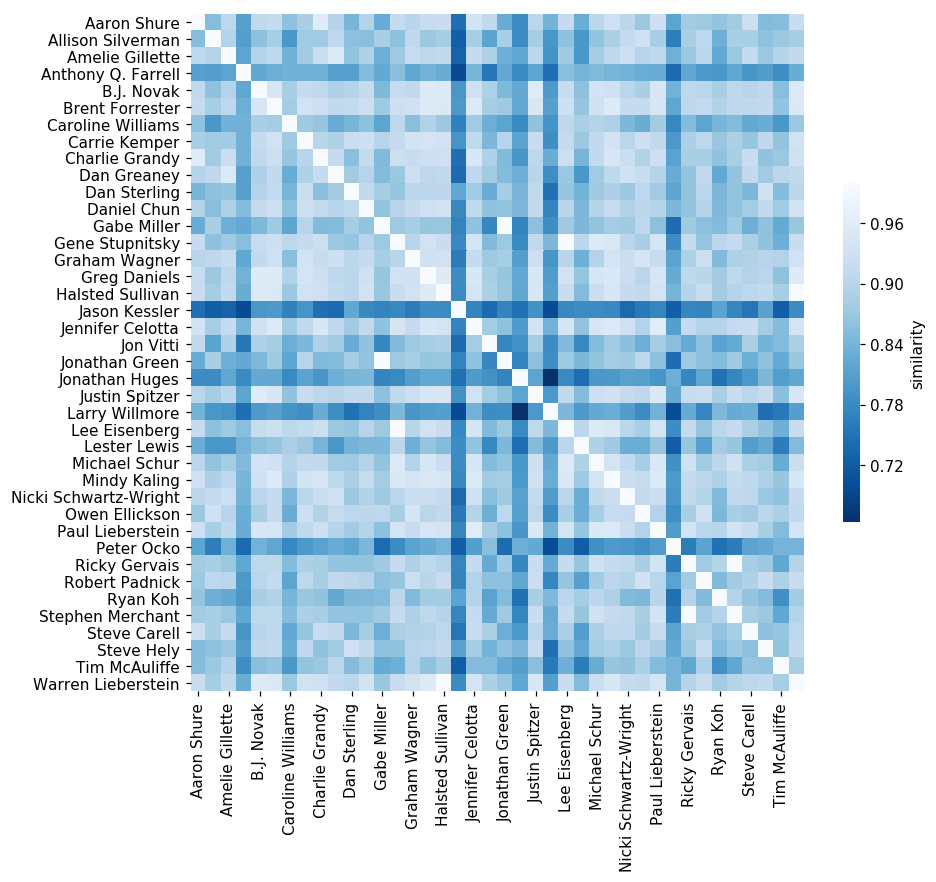

In [35]:
fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(get_similarity(vecs), cmap='Blues_r', cbar_kws=dict(label='similarity', shrink=.5), ax=ax)
ax.set_xlabel(''), ax.set_ylabel('');

We drill down to find the most and least similar pairs of writers:

In [36]:
sims = get_similarity(vecs, pivot=False)
sims = sims[sims['k1'] < sims['k2']]
sims = sims.sort_values('s', ascending=False).reset_index(drop=True)

In [37]:
sims.head(10)

k1                  k2         s
0   Gene Stupnitsky       Lee Eisenberg  1.000000
1     Ricky Gervais    Stephen Merchant  1.000000
2       Gabe Miller      Jonathan Green  1.000000
3  Halsted Sullivan  Warren Lieberstein  1.000000
4  Jennifer Celotta    Paul Lieberstein  0.960910
5        B.J. Novak      Justin Spitzer  0.959545
6       Aaron Shure      Charlie Grandy  0.958684
7      Greg Daniels  Warren Lieberstein  0.957482
8      Greg Daniels    Halsted Sullivan  0.957482
9   Brent Forrester        Mindy Kaling  0.955770

In [38]:
sims.tail(10)

k1                     k2         s
770       Jason Kessler  Nicki Schwartz-Wright  0.736889
771     Amelie Gillette          Jason Kessler  0.729215
772   Allison Silverman          Jason Kessler  0.725014
773       Jason Kessler             Peter Ocko  0.723792
774       Jason Kessler          Tim McAuliffe  0.722823
775        Lester Lewis             Peter Ocko  0.721125
776      Larry Willmore             Peter Ocko  0.699528
777  Anthony Q. Farrell          Jason Kessler  0.698549
778       Jason Kessler         Larry Willmore  0.697979
779      Jonathan Huges         Larry Willmore  0.663215

Finally, we sort individual writers by overall similarity with all others:

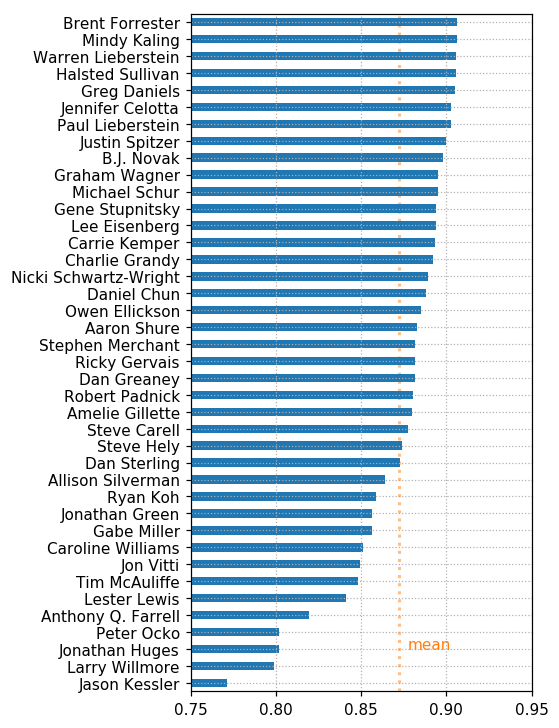

In [39]:
fig, ax = plt.subplots(figsize=(4,8))
sims = get_similarity(vecs, pivot=False)
sims.groupby('k1')[['k1', 's']].mean().sort_values(by='s').plot.barh(ax=ax, legend=False)
m = sims['s'].mean()
ax.axvline(m, color='C1', alpha=.5, zorder=-10, lw=2, ls=':')
ax.text(m+.005, 2, 'mean', color='C1')
ax.set_ylabel('')
ax.set_xlim(.75, .95)
ax.grid(ls=':');

**Thoughts:** It's kind of perfect that, by these metrics, Mindy is *the most typical* writer involved in the show.

If you Google Jason Kessler, you find: 

*Jason Eric Kessler (born September 22, 1983) is an American white supremacist. Kessler organized the Unite the Right rally held in Charlottesville, Virginia on ...*

I guess that's probably someone else?

### Season similarity

Did the writing vocabulary change over time?

In [40]:
ax = sns.heatmap(get_similarity(get_vecs('season')), cmap='Blues_r', cbar_kws=dict(label='similarity'))
ax.set_xlabel('Season'), ax.set_ylabel('Season');

In [41]:
season_similaritys = get_similarity(get_vecs('season'), pivot=False)
season_similaritys['dseason'] = season_similaritys['k2'] - season_similaritys['k1']
season_similaritys = season_similaritys[season_similaritys['dseason'] > 0]

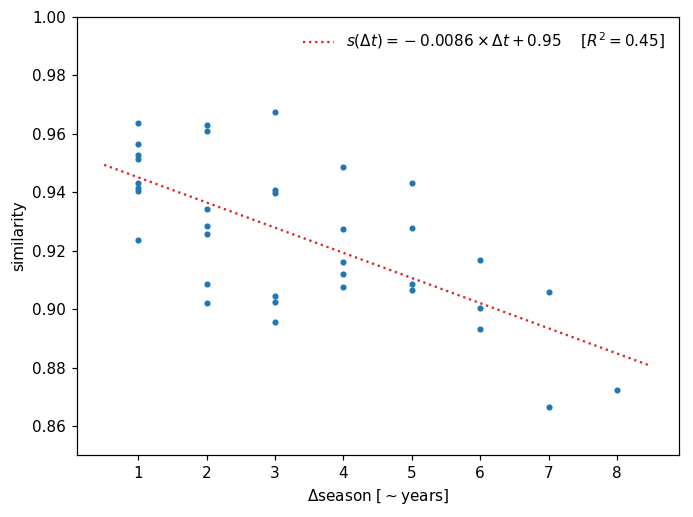

In [42]:
fig, ax = plt.subplots()
x, y = season_similaritys['dseason'].values, season_similaritys['s'].values
ax.plot(x, y, '.')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xx = np.linspace(.5, 8.5, 50)
ax.plot(xx, slope * xx + intercept, color='C3', ls=':',
        label=r'$s(\Delta t)={:.4f} \times \Delta t + {:.2f}\quad$ [$R^2={:.2f}$]'.format(slope, intercept, r_value**2))
leg = ax.legend()
leg.get_frame().set_visible(False)
ax.set_xlabel('$\Delta$season [$\sim$years]')
ax.set_ylabel('similarity')
ax.set_ylim(.85, 1)
plt.tight_layout()

**Thoughts:** It appear that the vocabulary shifts over time.  Specifically: for any pair of seasons, the more years there are between them, the less similar are their vocabularies.

### Episode similarity

We can scrape the original episode air dates from Wikipedia:

In [43]:
wiki_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_The_Office_(American_TV_series)_episodes')[:10]

In [44]:
episode_dates_by_season = {s: pd.to_datetime(wiki_tables[s].iloc[1:][5]).values for s in range(1,10)}

In [45]:
data['date'] = np.empty(len(data), dtype=np.datetime64)
for s in range(1, 10):
    d = data[data['season'] == s]
    for (i_e, e) in enumerate(d['episode'].unique()):
        data.loc[(data['season'] == s) & (data['episode'] == e), 'date'] = episode_dates_by_season[s][i_e]

Since this may be pretty fragile, we manually inspect the episode-date mapping:

In [46]:
for ((s,e), d) in data.groupby(['season', 'episode']):
    print(f'S{s:02d}E{e:02d} -- {d["date"].values[0]}')

S01E01 -- 2005-03-24T00:00:00.000000000
S01E02 -- 2005-03-29T00:00:00.000000000
S01E03 -- 2005-04-05T00:00:00.000000000
S01E04 -- 2005-04-12T00:00:00.000000000
S01E05 -- 2005-04-19T00:00:00.000000000
S01E06 -- 2005-04-26T00:00:00.000000000
S02E01 -- 2005-09-20T00:00:00.000000000
S02E02 -- 2005-09-27T00:00:00.000000000
S02E03 -- 2005-10-04T00:00:00.000000000
S02E04 -- 2005-10-11T00:00:00.000000000
S02E05 -- 2005-10-18T00:00:00.000000000
S02E06 -- 2005-11-01T00:00:00.000000000
S02E07 -- 2005-11-08T00:00:00.000000000
S02E08 -- 2005-11-15T00:00:00.000000000
S02E09 -- 2005-11-22T00:00:00.000000000
S02E10 -- 2005-12-06T00:00:00.000000000
S02E11 -- 2006-01-05T00:00:00.000000000
S02E12 -- 2006-01-12T00:00:00.000000000
S02E13 -- 2006-01-19T00:00:00.000000000
S02E14 -- 2006-01-26T00:00:00.000000000
S02E15 -- 2006-02-02T00:00:00.000000000
S02E16 -- 2006-02-09T00:00:00.000000000
S02E17 -- 2006-03-02T00:00:00.000000000
S02E18 -- 2006-03-16T00:00:00.000000000
S02E19 -- 2006-03-30T00:00:00.000000000


Seems legit.  Off we go:

In [47]:
sims = get_similarity(get_vecs('date'), pivot=False)
sims['dt'] = sims['k2'] - sims['k1']
sims = sims[sims['dt'] > np.timedelta64(0)]
sims['dt_years'] = [pd.Timedelta(dt).days / 365.25 for dt in sims['dt']]

In [48]:
fig, ax = plt.subplots()
x, y = sims['dt_years'].values, sims['s'].values
ax.plot(x, y, '.', alpha=.1, ms=3)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xx = np.linspace(-0.25, 8.25, 50)
ax.plot(xx, slope * xx + intercept, color='C3', ls=':',
        label=r'$s(\Delta t)={:.4f} \times \Delta t + {:.2f}\quad$ [$R^2={:.4f}$]'.format(slope, intercept, r_value**2))
leg = ax.legend()
leg.get_frame().set_visible(False)
ax.set_xticks(range(9))
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('similarity')
plt.tight_layout()

The trend line remains flat when outliers and large lag times are excluded:

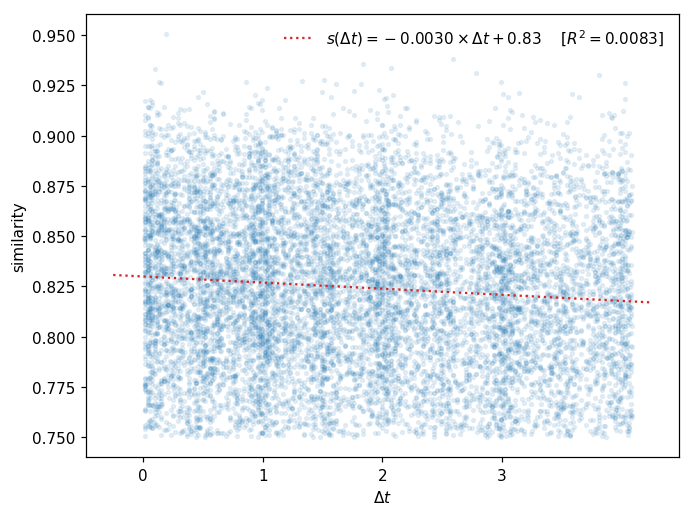

In [49]:
fig, ax = plt.subplots()
x, y = sims['dt_years'].values, sims['s'].values
mask = (x < 4.1) & (y > .75)
x, y = x[mask], y[mask]
ax.plot(x, y, '.', alpha=.1, ms=5)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xx = np.linspace(-0.25, 4.25, 50)
ax.plot(xx, slope * xx + intercept, color='C3', ls=':',
        label=r'$s(\Delta t)={:.4f} \times \Delta t + {:.2f}\quad$ [$R^2={:.4f}$]'.format(slope, intercept, r_value**2))
leg = ax.legend()
leg.get_frame().set_visible(False)
ax.set_xticks(range(4))
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('similarity')
plt.tight_layout()

**Thoughts:** It looks like there's enough variance in vocabulary from episode to episode that it's difficult to resolve any time-dependent decorrelation.